# MLP as universal approximator

##### Keywords: MLP, neural network, pytorch, SGD

## What is a perceptron

A perceptron is simply a set-of-units with a construction reminiscent of logistic regression. It consists of an input, followed by a linear combination, and then a squeezing through a non-linearity such as a sigmoid, a tanh, or a RELU.

![](images/perceptron.png)

A multi-layer perceptron can be used to approximate any function. The **Universal Approximation** theorem states that any continuous function with finite support can be approximated by at-least a one hidden layer based perceptron.

This is not a free lunch. The number of units required in this layer may be very high, and it might be hard for SGD to actually find the "correct" combination.

## Generate data

We generate noisy data from a fairly complex function (in 1-D) to demonstrate:

In [1]:
import numpy as np
#np.random.seed(99)
f = lambda x: 0.2 + 0.4*x**2 + 0.3*x*np.sin(15*x) + 0.05*np.cos(20*x)
xgrid = np.linspace(0.,1., 640)
fgrid = f(xgrid)
ygrid = fgrid + 0.1*np.random.normal(size=640)

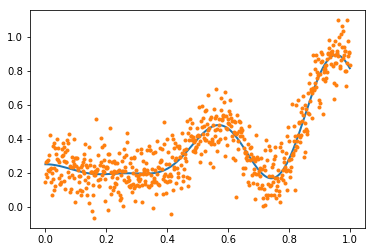

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(xgrid, fgrid, lw=2)
plt.plot(xgrid, ygrid, '.')


## Fitting in Torch

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as fn

In [7]:
from torch.autograd import Variable

xdata = Variable(torch.Tensor(xgrid))
ydata = Variable(torch.Tensor(ygrid))

## The model

Here is a general model class to fit an architecture of the style shown below:

![](images/mlp.png)

The basic structure is this: there is an input into a linear layer, which is then squeezed through a non-linearity. 0 or more hidden layers follow (we want atleast 1 hidden layer for universal approximation). At each of these layers, for each unit, we take all the output from the previous nonlinearity, linear-combine it with all the other non-linear outputs from the previous layer, and squeeze what we get through another non-linearity. Finally, we combine all these non-liner outputs using a linear unit into a y value. (we'd use a linear+sigmoid or linear+softmax for categorical outputs or classification).

The class below makes the structure explicit. Notice the use of `nn.ModuleList`. This is a `pytorch` peculiarity.

In [8]:
class MLRegP(nn.Module):
    def __init__(self, input_dim, hidden_dim, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(MLRegP, self).__init__()
        self.fc_initial = nn.Linear(input_dim, hidden_dim)
        self.fc_mid = nn.ModuleList()
        self.additional_hidden_wide = additional_hidden_wide
        for i in range(self.additional_hidden_wide):
            self.fc_mid.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc_final = nn.Linear(hidden_dim, 1)
        self.nonlinearity = nonlinearity

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.nonlinearity(x)
        for i in range(self.additional_hidden_wide):
            x = self.fc_mid[i](x)
            x = self.nonlinearity(x)
        x = self.fc_final(x)
        return x

## RELU example with 1 additional layer.

We choose 1 hidden layer with 40 units. We print out the model to see what we get. The graph is built up by `pytorch` when `forward` is hit for the first time (thats how we can get away putting the nonlinearities there). Then when we backprop the gradients are transferred properly.

In [9]:
model = MLRegP(1, 40, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.MSELoss()

In [10]:
print(model)

MLRegP(
  (fc_initial): Linear(in_features=1, out_features=40)
  (fc_mid): ModuleList(
    (0): Linear(in_features=40, out_features=40)
  )
  (fc_final): Linear(in_features=40, out_features=1)
)


In [11]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xgrid.reshape(-1,1)), torch.from_numpy(ygrid))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

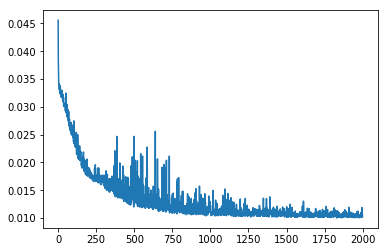

In [12]:
lr, epochs, batch_size = 1e-1 , 2000 , 64
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for localx, localy in iter(loader):
        localx = Variable(localx.float())
        localy = Variable(localy.float())
        output = model.forward(localx)
        loss = criterion(output, localy)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

In [13]:
finaloutput = model.forward(xdata.view(-1,1))

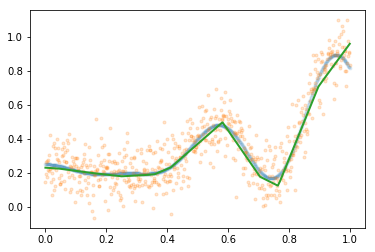

In [26]:
plt.plot(xgrid, fgrid, '.', alpha=0.1)
plt.plot(xgrid, ygrid, '.', alpha=0.2)
plt.plot(xgrid, finaloutput.data.numpy(), lw=2)

We see that RELU does a decent job. Because of the nature of RELU, the resulting function has sharp edges. Note that even though the universal approximation theorem says that we can approximate any function, stochastic noise means that the function the network thinks we are approximating need not be the function we want to approximate..

## tanh nonlinearity

We get somewhat better results with the tanh nonlinearity. Play with the number of hidden layers and number of units per layer to see if you can do better!

MLRegP(
  (fc_initial): Linear(in_features=1, out_features=40)
  (fc_mid): ModuleList(
    (0): Linear(in_features=40, out_features=40)
  )
  (fc_final): Linear(in_features=40, out_features=1)
)


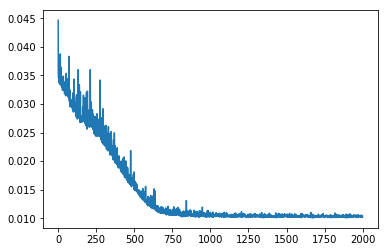

In [27]:
model2 = MLRegP(1, 40, nonlinearity=fn.tanh, additional_hidden_wide=1)
print(model2)
criterion = nn.MSELoss()
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xgrid.reshape(-1,1)), torch.from_numpy(ygrid))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
lr, epochs, batch_size = 1e-1 , 2000 , 64
optimizer = torch.optim.SGD(model2.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for localx, localy in iter(loader):
        localx = Variable(localx.float())
        localy = Variable(localy.float())
        output = model2.forward(localx)
        loss = criterion(output, localy)
        model2.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

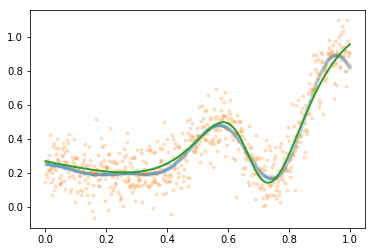

In [28]:
finaloutput = model2.forward(xdata.view(-1,1))
plt.plot(xgrid, fgrid, '.', alpha=0.1)
plt.plot(xgrid, ygrid, '.', alpha=0.2)
plt.plot(xgrid, finaloutput.data.numpy(), lw=2)